In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter
import numpy as np
import random
import time

In [2]:

class Spike1d(torch.nn.Module):
    def __init__(self, n_in,n_out, thresh = 1, input_connections = [], mod = True):
        super(Spike1d, self).__init__()
        self.potentials = Parameter(torch.zeros(n_out, dtype=torch.float),requires_grad=False)
        self.thresh = thresh
        self.mod = mod
        self.n_out = n_out
            
        try:
            self.fc =[nn.Linear(n_in,n_out,bias = False)]
            self.n_weight_matrices = 1
        except:
            fc = []
            for idx,i in enumerate(n_in):
                if idx in input_connections:
                    fc.append(0)
                else:
                    fc.append(nn.Linear(i,n_out,bias = False))
            
            self.fc = fc
                
    def get_empty_spikes(self):
        return torch.zeros([self.n_out])
    
    def forward(self, x):
        
        #update potentials
        delta_p = torch.zeros([self.n_out])
        for idx,f in enumerate(self.fc):
            try:
                delta_p += torch.abs(f(x[idx]))
            except:
                delta_p += x[idx]
                
        self.potentials = Parameter(self.potentials + delta_p)
        
        #generate spikes
        spikes = (self.potentials >= self.thresh).float()
        
        #change potentials of spiked neurons
        if self.mod:
            #After spike overflow is kept
            self.potentials = Parameter(self.potentials - (spikes * self.thresh))
        else:
            #After spike potential is set to zero removing any overlow
            self.potentials = Parameter(self.potentials * (1 - spikes))

        
        return spikes, (self.potentials + spikes)
    
class Net(nn.Module):
    def __init__(self, mod = False):
        super(Net, self).__init__()
        self.spike1 = Spike1d([2,4],2, input_connections = [0], mod = False)
        self.odd_spikes = self.spike1.get_empty_spikes()
        
        self.spike2 = Spike1d([2],4, mod = mod)
        self.even_spikes = self.spike2.get_empty_spikes()

        
    def forward(self, x):
        spikes = []
        
        #Update every odd layer
        self.odd_spikes, pots = self.spike1([x,self.even_spikes])
        spikes.append(pots)
        
        
        #Update every even layer
        self.even_spikes, pots = self.spike2([self.odd_spikes])
        spikes.append(pots)
        
    
        
        return x, spikes


<IPython.core.display.Javascript object>


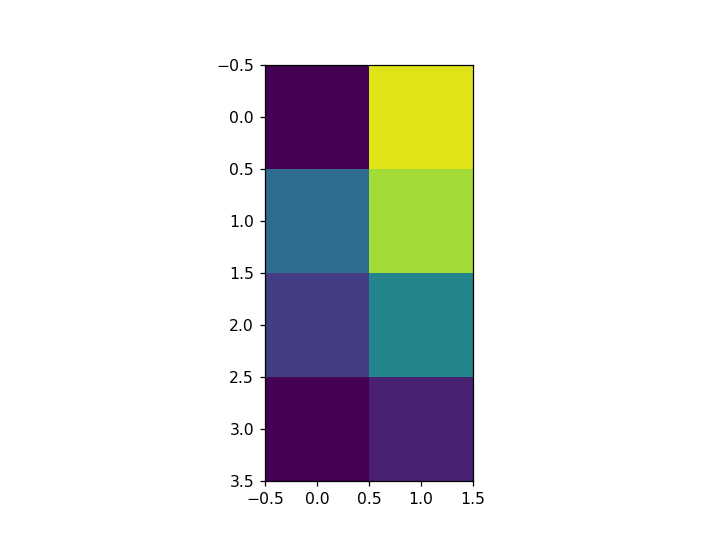

C:\Users\Liam\Miniconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [3]:
model = Net(mod = False)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

def draw_spikes(spikes, ax):
    l_dim = 0
    for i in spikes:
        if i.shape[0] > l_dim:
            l_dim = i.shape[0]
         
    spikes_ = torch.zeros(len(spikes),l_dim) - 0.1
    
    
    for i in range(len(spikes)):
        d = (l_dim - spikes[i].shape[0]) // 2
        spikes_[i][d:spikes[i].shape[0] + d] = torch.tensor(spikes[i])
        
    spikes_ = spikes_.t()
    
    ax.clear()
    ax.imshow(spikes_,vmin=-0.1, vmax=1)
    

x_fire = np.array(random.sample(range(1,150), 15))
y_fire =[]# x_fire + 2

for e in range(150):
    in_spike = torch.tensor([e in x_fire,e in y_fire], dtype=torch.float)
    #print(in_spike)
    #out,spikes = model(torch.tensor([0.5]*2, dtype=torch.float))#torch.randn(1, dtype=torch.float))
    
    out,spikes = model(in_spike)#torch.randn(1, dtype=torch.float))
    #print(in_spike)
    draw_spikes(spikes, ax)
    fig.canvas.set_window_title("Step : {},   {}".format(e,in_spike.data))
    fig.canvas.draw()
    time.sleep(0.1)